In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

sns.set_theme(style='whitegrid')

In [2]:
# read in congress info
congress_info = pd.read_csv('data/congressmember_data.csv')

In [3]:
# read in ratio data
df = pd.read_csv('data/tweet_data.csv')

In [4]:
# calculate the ratio for each tweet as 
# (quotes + replies - retweets) / (quotes + replies + retweets)
df['ratio'] = ((df['retweeted__quote_count'] + df['retweeted__reply_count'] - df['retweeted__retweet_count']) /
               (df['retweeted__retweet_count'] + df['retweeted__quote_count'] + df['retweeted__reply_count']))

In [5]:
# calculate the mean, median, and standard error of the mean for each MoC
stats = df.groupby('retweeted__user__name')['ratio'].aggregate([np.mean, np.median, scipy.stats.sem])

/home/mab1242/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mab1242/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
# select the top 20 most ratioed MOCs
users = stats.sort_values('median', ascending=False)[:20].index.tolist()

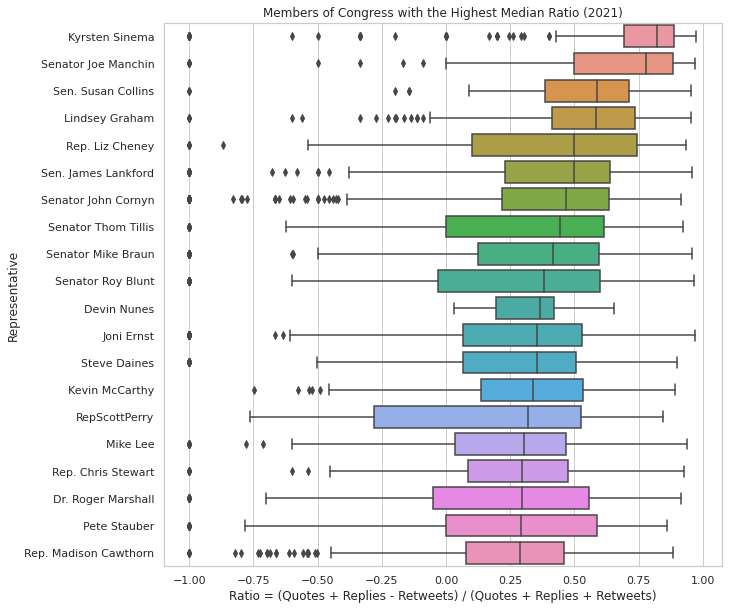

In [7]:
# create a box plot for the top 20 users

# filter to the top twenty users and rename columns to be pretty for the fig
data_to_output = df[df['retweeted__user__name'].isin(users)].copy()
data_to_output.rename({'retweeted__user__name':'Representative',
                       'ratio':'Ratio = (Quotes + Replies - Retweets) / (Quotes + Replies + Retweets)'}, axis=1, inplace=True)

# plot the figure
plt.figure(figsize=(10, 10))
sns.boxplot(data=data_to_output, y='Representative', x='Ratio = (Quotes + Replies - Retweets) / (Quotes + Replies + Retweets)', order=users)
plt.title('Members of Congress with the Highest Median Ratio (2021)')
plt.ylabel('Representative')
plt.savefig('figures/highest_ratioed_mocs.png', dpi=600, bbox_inches="tight")

In [8]:
# join the max rows dataframe with the congress metadata
merged = pd.merge(df, congress_info, on='screen_name', how='inner')

In [9]:
def apply_quantile(num):
    '''
    returns the quartile of the ratio for all the tweets in the dataset
    '''
    if num <= merged['ratio'].quantile(.25):
        return 'First Quartile\nLeast Ratioed'
    if num <= merged['ratio'].quantile(.50):
        return 'Second Quartile'
    if num <= merged['ratio'].quantile(.75):
        return 'Third Quartile'
    return 'Fourth Quartile\nMost Ratioed'
    

In [10]:
# apply the quantile to the ratioed tweets
merged['quantile'] = merged['ratio'].progress_apply(apply_quantile)

100%|██████████| 78731/78731 [04:05<00:00, 320.80it/s]


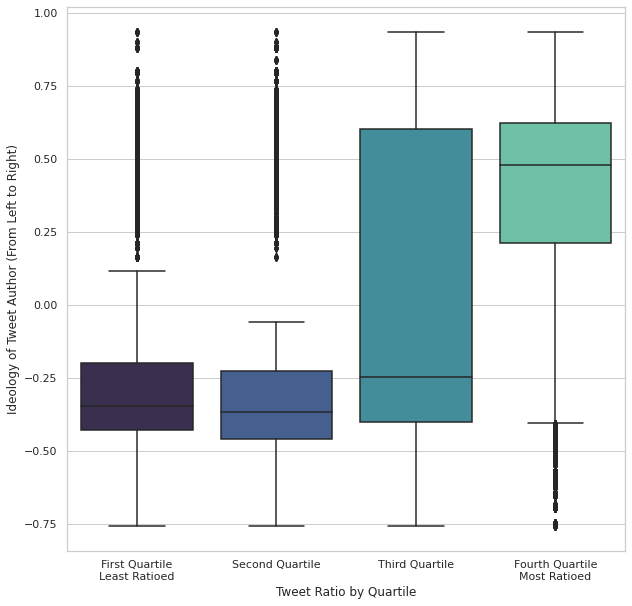

In [11]:
# plot the distribution of ideology by quantile
# rename columns to be prettier
data_to_output = merged.copy()
data_to_output.rename({'quantile':'Tweet Ratio by Quartile', 
                       'nominate_dim1':'Ideology of Tweet Author (From Left to Right)'}, axis=1, inplace=True)

# plot the ideology box plots for each ratio quartile
plt.figure(figsize=(10, 10))
sns.boxplot(data=data_to_output, x='Tweet Ratio by Quartile', 
            y='Ideology of Tweet Author (From Left to Right)', 
            order=reversed(['Fourth Quartile\nMost Ratioed', 'Third Quartile', 'Second Quartile', 'First Quartile\nLeast Ratioed']), palette="mako")
plt.savefig('figures/ideology_by_ratio_quartile.png', dpi=600, bbox_inches="tight")

In [12]:
# drop na records so we don't get an na regression
dropna = merged[['ratio', 'nominate_dim1']].dropna()
# calculate the mean for each MoC
dropna = dropna.groupby('nominate_dim1')['ratio'].mean().reset_index()
# estimate the linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dropna)

In [13]:
print('slope', slope)
print('p_value', p_value)

slope 0.42814329975943083
p_value 8.345448234420265e-56


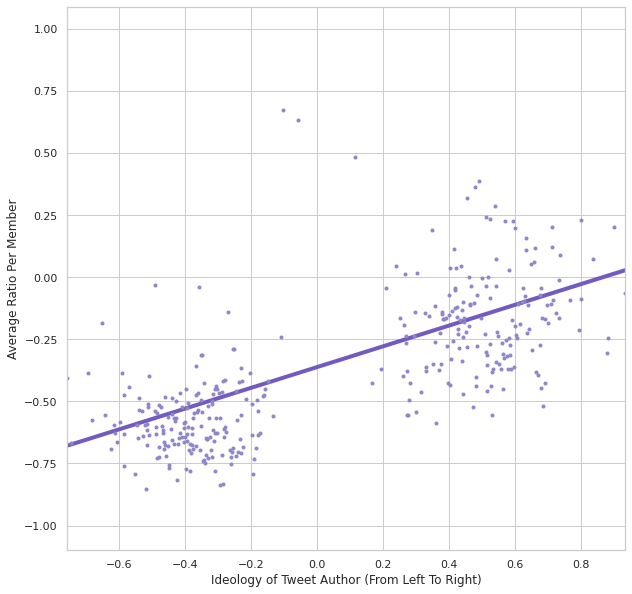

In [14]:
plt.figure(figsize=(10, 10))

# rename data for pretty figs
data_to_output = merged.copy()
data_to_output.rename({'ratio':'Average Ratio Per Member', 
                       'nominate_dim1':'Ideology of Tweet Author (From Left To Right)'}, axis=1, inplace=True)

# plot the linear regression
g = sns.regplot(data=data_to_output, y='Average Ratio Per Member', x='Ideology of Tweet Author (From Left To Right)',
                scatter_kws={'alpha':0, 'color':'#8D86C9'}, line_kws={'linewidth':4, 'color':'#725AC1'})

# plot the dots per member
to_plot = data_to_output.groupby('Ideology of Tweet Author (From Left To Right)')['Average Ratio Per Member'].mean()
g.plot(to_plot, '.', color='#8D86C9')

plt.xlabel('Ideology of Tweet Author (From Left To Right)')
plt.savefig('figures/linear_regression.png', dpi=600, bbox_inches="tight")